In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import Qobj, basis, destroy, tensor
from chalmers_qubit.sarimner.processor import SarimnerProcessor
from chalmers_qubit.sarimner.model import SarimnerModel
from chalmers_qubit.sarimner.noise import DecoherenceNoise, ZZCrossTalk
from chalmers_qubit.base.operations import project_on_qubit

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

%load_ext autoreload
%autoreload 2

## Longitudinal relaxation

**Initializing the Qubit System**

We start by initializing the parameters of our qubit system: the number of qubits, their frequencies, anharmonicities, and relaxation times $T_1$ and $T_2$. These parameters are essential for accurately modeling the qubit's physical behavior in our simulation. We create a `SarimnerProcessor` instance with these specified parameters to represent our qubit processor.

In [2]:
transmon_dict = {
    0: {"frequency": 5.0, "anharmonicity": -0.30},
}
decoherence_dict = {
    0: {"t1": 60e3, "t2": 80e3},
}

In [3]:
# Create the processor with the given hardware parameters
# Load the physical parameters onto the model
model = SarimnerModel(transmon_dict=transmon_dict)

# Add noise
noise = [DecoherenceNoise(decoherence_dict=decoherence_dict)]

# Create the processor with the given hardware parameters
sarimner = SarimnerProcessor(model=model, noise=noise)

**Simulating the Qubit System**

Next, we simulate the master equation to study the qubit's dynamics over time. The simulation begins with the qubit in its excited state, represented by `rho`. We aim to observe how the qubit relaxes back to its ground state over a total time of 200 ns, sampled at 30 points (`tlist`) by measuring the expecation value of the number operator $\hat a^\dagger \hat a$.

In [4]:
# master equation simulation
vac = basis(3,0)
a = destroy(3)
rho = a.dag() * vac
e_ops = [a.dag()*a]
t_total = 200*1e3
tlist = np.linspace(0,t_total,30)
result = sarimner.run_state(rho, tlist=tlist, e_ops=e_ops)

**Plotting the Results**

Finally we can visualize the qubit's relaxation process and compare the simulation results with the theoretical prediction.

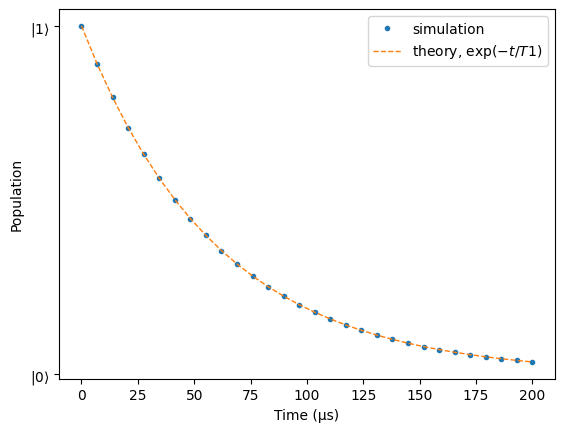

In [5]:
t = np.array(result.times)
t1 = decoherence_dict[0]["t1"]
plt.figure(1)
plt.plot(t/1e3, result.e_data[0], '.', linewidth=.5, label= r'simulation')
plt.plot(t/1e3, np.exp(-t/t1), '--', linewidth=1, label=r'theory, $\exp(-t/T1)$')
plt.yticks([0,1],[r'$|0\rangle$',r'$|1\rangle$'])
plt.xlabel(r"Time (μs)")
plt.ylabel(r'Population')
plt.legend();

## Transversal relaxation

To measure the transversal relaxation of the qubit, we adjust our system to operate in a slightly detuned rotating frame. This is achieved by setting the `rotating_frame_frequencies` slightly off from the qubit's resonance frequency (5.1 GHz instead of 5.0 GHz). This detuning is needed for observing the effects of transversal relaxation $T_2$ in the presence of a rotating frame.

In [6]:
transmon_dict_rot = {
    0: {"frequency": 5.0, "anharmonicity": -0.30, "rotating frame frequency": 5.02},
}

# Create the processor with the given hardware parameters
# Load the physical parameters onto the model
model = SarimnerModel(transmon_dict=transmon_dict_rot)

# Add noise
noise = [DecoherenceNoise(decoherence_dict=decoherence_dict)]

# Create the processor with the given hardware parameters
sarimner = SarimnerProcessor(model=model, noise=noise)

Next, we prepare the qubit in the plus-state that lies along the positive x-axis on the Bloch sphere, and we measure the expectation value of the number operator in the $X$-basis.

In [7]:
from qutip import Options
# Prepare qubit in plus state
rho = (basis(3,1) + basis(3,0)).unit()
Hadamard = 1/np.sqrt(2) * Qobj([[1,1,0],[1,-1,0],[0,0,0]])
e_ops = [Hadamard*a.dag()*a*Hadamard]
# Transmon Hamiltonian with a slight detuning
t_total = 200 * 1e3 # in (ns)
tlist = np.linspace(0, t_total, 500)
# master equation simulation
result = sarimner.run_state(rho, tlist=tlist, e_ops=e_ops, options=Options(nsteps=1e5))

Finally, we plot the results and compare the simulation to our theoretical prediction.

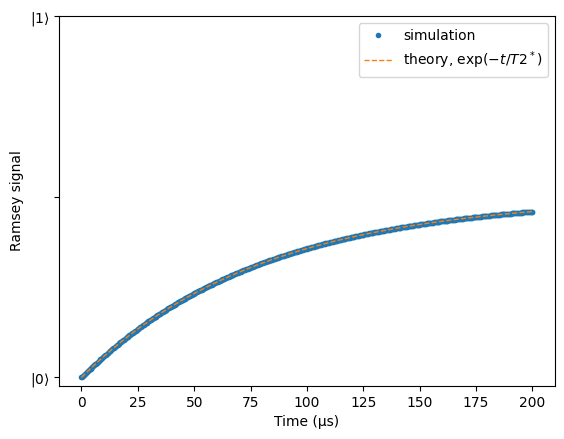

In [19]:
fig, ax = plt.subplots()
t2 = decoherence_dict[0]["t2"]
# detail about lenght of tlist needs to be fixed
ax.plot(tlist/1e3, result.expect[0], '.', linewidth = .5, label="simulation")
ax.plot(tlist/1e3, -(np.exp(-tlist/(t2))-1)/2, '--', linewidth = 1, label=r"theory, $\exp(-t/T2^*)$")
plt.yticks([0,.5,1], [r'$|0\rangle$','',r'$|1\rangle$'])
plt.xlabel(r"Time (μs)")
plt.ylabel(r"Ramsey signal")
plt.legend()

## Hahn-Echo

In [20]:
from qutip_qip.circuit import QubitCircuit

def spin_echo(tau):
    circuit = QubitCircuit(1)
    circuit.add_gate("RX", targets=0, arg_value=np.pi / 2)
    circuit.add_gate("IDLE", targets=0, arg_value=tau/2)
    circuit.add_gate("RX", targets=0, arg_value=np.pi)
    circuit.add_gate("IDLE", targets=0, arg_value=tau/2)
    circuit.add_gate("RX", targets=0, arg_value=np.pi/2)
    return circuit

In [21]:
# Create the processor with the given hardware parameters
# Load the physical parameters onto the model
model = SarimnerModel(transmon_dict=transmon_dict)

# Add noise
noise = [DecoherenceNoise(decoherence_dict=decoherence_dict)]

# Create the processor with the given hardware parameters
sarimner = SarimnerProcessor(model=model, noise=noise)

In [22]:
from tqdm import tqdm
# Initial state for the simulation.
init_state = basis(3, 0)
# Time list in (ns)
tlist = np.linspace(0,100*1e3,10)
# Expectation value of number operator
e_ops = [destroy(3).dag()*destroy(3)]
# Population
pop = []
# Total time
total_time = []
# Loop over times
for tau in tqdm(tlist):
    times, coeffs = sarimner.load_circuit(spin_echo(tau))
    # Get total time of simulation
    t_total = sarimner.get_full_tlist()[-1]
    # Run master equation simulation and save only start and end times
    result = sarimner.run_state(init_state, tlist=[0,t_total] , e_ops=e_ops, options=Options(nsteps=5e6))
    # Get result
    pop.append(result.expect[0][-1])
    total_time.append(t_total)

100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


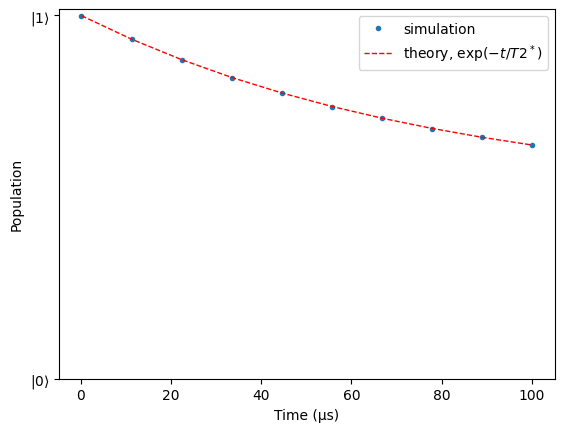

In [23]:
t2 = decoherence_dict[0]["t2"]
plt.plot(np.array(total_time)/1e3, 1-np.array(pop), '.', label='simulation')
plt.plot(np.array(total_time)/1e3, (np.exp(-np.array(total_time)/(t2))+1)/2, 'r--', linewidth = 1, label=r"theory, $\exp(-t/T2^*)$")
plt.xlabel(r"Time (μs)")
plt.ylabel(r"Population")
plt.yticks([0, 1], [r"$|0\rangle$", r"$|1\rangle$"]);
plt.legend()

## ZZ-crosstalk

ZZ-crosstalk is a phenomenon in quantum computing, particularly relevant in systems with superconducting qubits, where the interaction between two or more qubits leads to unwanted phase shifts in the qubits that are not being directly operated upon. This effect arises due to the residual coupling between qubits, even when they are not intentionally interacting. The "ZZ" refers to the interaction type, denoting the direct coupling between the Z components of the qubit state. ZZ-crosstalk lead to coherent phase errors 

In [24]:
transmon_dict = {
    0: {"frequency": 5.0, "anharmonicity": -0.30},
    1: {"frequency": 5.4, "anharmonicity": -0.30},
}
cross_talk_dict = {(0,1): 1e-3}

In [25]:
# Create the processor with the given hardware parameters
# Load the physical parameters onto the model
model = SarimnerModel(transmon_dict=transmon_dict)

# Add noise
noise = [ZZCrossTalk(cross_talk_dict=cross_talk_dict)]

# Create the processor with the given hardware parameters
sarimner = SarimnerProcessor(model=model, noise=noise)

In [26]:
# Prepare qubit in 11 state
rho = tensor(basis(3,1), basis(3,1))
# Transmon Hamiltonian with a slight detuning
t_total = 400 # in (ns)
tlist = np.linspace(0, t_total, 500)
# master equation simulation
result = sarimner.run_state(rho, tlist=tlist)

In [27]:
project_on_qubit(result.states[-1])

Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [-0.80902006-0.58778103j]]

Compute what the expected phase is

In [28]:
zz = cross_talk_dict[(0,1)]
np.around(np.exp(-1j*2*np.pi*zz*t_total),3)

(-0.809-0.588j)